# ML Практическая работа 6
## Мурадян Денис

### neural networks, deep learning

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("denismuradyan/cleaned-dataset-of-used-cars")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/cleaned-dataset-of-used-cars


In [3]:
import pandas as pd

df = pd.read_csv(f"{path}/cleaned_data_used_cars.csv")
df.head()

,id,price,year,condition,cylinders,odometer,title_status,description,posting_date,fuel_electric,...,transmission_manual,transmission_other,drive_fwd,drive_rwd,state_freq,region_freq,type_freq,paint_color_freq,te_model_oof,te_manufacturer_oof
0,7316356412,15000,2013,3,6,128000.0,0.0,2013 F-150 XLT V6 4 Door. Good condition. Leve...,2021-05-03 19:02:03,False,...,False,False,False,True,0.012329,0.000328,0.105321,0.209170,20228.583361,20136.757536
1,7316343444,27990,2012,2,8,68696.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 18:41:25,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.209170,24936.745669,24228.390664
2,7316304717,34590,2016,2,6,29499.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 17:41:33,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.148408,25099.600519,19914.615212
3,7316285779,35000,2019,3,6,43000.0,0.0,Selling my 2019 Toyota Tacoma TRD Off Road Dou...,2021-05-03 17:12:59,False,...,False,False,False,False,0.012329,0.000328,0.105321,0.095670,21119.239527,16356.129063
4,7316257769,29990,2016,2,6,17302.0,0.0,Carvana is the safer way to buy a car During t...,2021-05-03 16:31:14,False,...,False,True,False,False,0.012329,0.000328,0.126077,0.105005,22501.109375,20019.638000


## Цели и задачи работы

**Цель**

Исследовать качество различных архитектур нейронных сетей на задаче бинарной классификации стоимости автомобиля  
(таргет: `price > median(price)`), сравнить результаты моделей и влияние подбора гиперпараметров.

**Задачи**

1. Загрузить и подготовить данные в том же виде, что и в предыдущих практических работах.
2. Написать теоретическую справку по нейронным сетям в целом и по архитектурам:
   однослойный перцептрон (SLP), многослойный перцептрон (MLP), простая RNN и GRU.
3. Обучить для каждой из архитектур (SLP, MLP, RNN, GRU) две версии модели:
   базовую и с подбором гиперпараметров с помощью Optuna.
4. Оценивать качество моделей с помощью метрик: Accuracy, Precision, Recall, macro-F1, ROC-AUC и LogLoss.
5. Построить для всех моделей графики обучения по эпохам (train/valid loss).
6. Сравнить между собой SLP, MLP, RNN и GRU, а также базовые варианты и модели с Optuna, и сделать выводы о том, какие архитектуры и конфигурации лучше подходят для текущей задачи.

## Теоретическая справка

### Нейронные сети в общем виде

Нейронная сеть можно представить как несколько последовательно применяемых слоев.  
Каждый слой принимает на вход вектор признаков и выдаёт новый вектор, обычно той же или другой размерности.  
Внутри слоя есть набор нейронов, каждый из которых считает взвешенную сумму входов и пропускает её через нелинейную функцию активации.

Базовый нейрон:

$$
z = w^\top x + b, \qquad a = \sigma(z),
$$

где  
$\,x \in \mathbb{R}^d$ - вход,  
$\,w \in \mathbb{R}^d$ - веса,  
$\,b \in \mathbb{R}$ - смещение,  
$\,\sigma(\cdot)$ - активация (ReLU, $\tanh$, сигмоида и т.д.).

Для бинарной классификации обычно делают один выходной нейрон с сигмоидой:

$$
\hat y = \sigma(z) = \frac{1}{1 + e^{-z}}, \qquad \hat y \in (0,1),
$$

и интерпретируют $\hat y$ как оценку вероятности класса 1.

Частая функция потерь здесь это (cross-entropy loss или logloss):

$$
\mathcal{L}(\hat y, y) = - \bigl[ y \log(\hat y) + (1 - y)\log(1 - \hat y) \bigr],
$$

где $y \in \{0,1\}$ - истинная метка.

Обновление весов по градиентному спуску:

$$
w^{(k+1)} = w^{(k)} - \eta \, \nabla_w \mathcal{L},
$$

где $\eta$ - шаг обучения.  
Градиенты по всем слоям считаются методом обратного распространения ошибки (backpropagation).



### Однослойный перцептрон (SLP)

С точки зрения архитектуры однослойный перцептрон - это минимально возможная сеть:

- входной слой (признаки),
- один выходной нейрон.

То есть нет "скрытых" слоев: каждый признак напрямую связан с выходом через свой вес.

Математически:

$$
z = w^\top x + b, \qquad \hat y = \sigma(z),
$$

где $\sigma$ - сигмоида для бинарной классификации.

Особенности:

- разделяющая поверхность - гиперплоскость в пространстве признаков;
- модель умеет реализовывать только линейное разделение классов;
- мало параметров, быстро обучается;
- не может выучить сложные нелинейные зависимости между признаками.

В этой работе SLP - базовый ориентир: "честная" простая нейросеть без скрытых слоев.



### Многослойный перцептрон (MLP)

MLP - это уже несколько полносвязных (Dense) слоев подряд:

- входной слой (признаки),
- один или несколько скрытых слоев с некоторым количеством нейронов,
- выходной слой (один нейрон с сигмоидой для бинарной классификации).

Простейший вариант с одним скрытым слоем:

$$
h = \phi(W_1 x + b_1), \\
\hat y = \sigma(W_2 h + b_2),
$$

где  
$W_1, b_1$ - обучаемые параметры скрытого слоя,  
$W_2, b_2$ - параметры выходного слоя,  
$\phi(\cdot)$ - нелинейная активация (например, ReLU).

Для нескольких скрытых слоев:

$$
h^{(1)} = \phi_1(W_1 x + b_1), \\
h^{(2)} = \phi_2(W_2 h^{(1)} + b_2), \\
\ldots \\
\hat y = \sigma(W_L h^{(L-1)} + b_L).
$$

За счёт нескольких нелинейных слоев MLP может моделировать сложные зависимости между признаками и таргетом.  
На практике для табличных данных часто достаточно 1-2 скрытых слоев с умеренным числом нейронов, плюс регуляризация (L2, dropout), чтобы не переобучиться.



### Простая рекуррентная нейронная сеть (RNN)

Архитектурно RNN отличается от MLP тем, что один и тот же "рекуррентный блок" применяется последовательно к элементам входной последовательности.  
То есть у нас есть:

- входная последовательность $x_1, \dots, x_T$,
- один рекуррентный слой (или несколько, если их стекать),
- на каждом шаге используется одно и то же множество весов.

Формулы для одного рекуррентного слоя:

$$
h_t = \phi(W_x x_t + W_h h_{t-1} + b_h), \\
y_t = \psi(W_y h_t + b_y),
$$

где  
$h_t$ - скрытое состояние в момент времени $t$,  
$W_x, W_h, W_y$ - матрицы весов,  
$\phi(\cdot)$ - нелинейность (обычно $\tanh$ или ReLU),  
$\psi(\cdot)$ - активация на выходе (например, сигмоида).

Состояние $h_t$ аккумулирует информацию о предыдущих шагах $x_1, \dots, x_t$.  
В классических RNN при длинных последовательностях возникают проблемы исчезающих и взрывающихся градиентов:  
градиенты содержат большое количество произведений матриц и производных, что ведёт к очень маленьким или очень большим значениям.

В нашей задаче данные табличные. Чтобы использовать RNN, можно интерпретировать вектор признаков как короткую "последовательность" и пропустить её через один рекуррентный слой, а затем взять итоговое состояние $h_T$ и подать его на выходной полносвязный слой.



### GRU (Gated Recurrent Unit)

GRU - это тоже рекуррентный слой, но внутри одной ячейки архитектура сложнее:  
вместо одного обновления состояния используются "затворы" (gates), которые решают, сколько информации оставить из прошлого и сколько взять из нового входа.  
По архитектуре это всё ещё один слой, но с несколькими параллельными линейными преобразованиями и сигмоидальными активациями для затворов.

Формулы GRU:

1. Update gate $z_t$ (задаёт, насколько сильно обновлять состояние):

$$
z_t = \sigma(W_z x_t + U_z h_{t-1} + b_z).
$$

2. Reset gate $r_t$ (управляет тем, какую часть старого состояния учитывать):

$$
r_t = \sigma(W_r x_t + U_r h_{t-1} + b_r).
$$

3. Кандидатное состояние $\tilde h_t$:

$$
\tilde h_t = \tanh\bigl(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h\bigr),
$$

где $\odot$ - поэлементное умножение.

4. Итоговое состояние:

$$
h_t = (1 - z_t) \odot h_{t-1} + z_t \odot \tilde h_t.
$$

Интерпретация:

- $z_t$ регулирует "смесь" старого состояния $h_{t-1}$ и нового кандидата $\tilde h_t$,
- $r_t$ управляет тем, насколько мы "забываем" прошлое перед вычислением кандидата.

Архитектурно GRU-слой можно использовать так же, как обычный RNN-слой:  
на вход идет последовательность векторов, на выходе - последовательность состояний или только последнее состояние.  
По сравнению с простой RNN, GRU обычно лучше держит информацию на длинных промежутках и обучается стабильнее.


## Подготовка данных

Повторим ключевые шаги подготовки.

1) Удаление служебных признаков: `id`, `description`, `posting_date`.  
2) Булевы индикаторы (`fuel_*`, `transmission_*`, `drive_*`) -> `int` (0/1).  
3) Удаление пропусков по `title_status`.  
4) Целевой признак: `target = (price > median(price))`, затем `price` удалить.  
5) Признаки: берем все оставшиеся числовые столбцы, кроме `target`.  
6) Разбиение: `train/valid/test = 70/15/15`, `stratify=target`, `random_state=42`.  
7) Масштабирование признаков `StandardScaler` по обучающей выборке

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# убрать служебные
drop_cols = [c for c in ["id", "description", "posting_date"] if c in df.columns]
df = df.drop(columns=drop_cols)

# bool -> int
bool_cols = df.select_dtypes(include=["bool"]).columns
if len(bool_cols) > 0:
    df[bool_cols] = df[bool_cols].astype(int)

# пропуски
if "title_status" in df.columns:
    df = df.dropna(subset=["title_status"])

# целевой и удаление price
median_price = df["price"].median()
df["target"] = (df["price"] > median_price).astype(int)
if "price" in df.columns:
    df = df.drop(columns=["price"])

# признаки = все оставшиеся числовые колонки, кроме target
TARGET = "target"
feature_cols = [c for c in df.columns if c != TARGET]
X_full = df[feature_cols].select_dtypes(include=[np.number]).copy()
y_full = df[TARGET].copy()

# если остались NaN в признаках - удалим такие строки
mask_nan = X_full.isna().any(axis=1)
n_drop = int(mask_nan.sum())
if n_drop > 0:
    idx = X_full.index[mask_nan]
    df = df.drop(index=idx).reset_index(drop=True)
    X_full = df[[c for c in df.columns if c != TARGET]].select_dtypes(include=[np.number]).copy()
    y_full = df[TARGET].copy()

print("Features used:", X_full.shape[1])

# сплиты 70/15/15
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X_full, y_full, test_size=0.15, stratify=y_full, random_state=42
)
valid_size = 0.15 / 0.85
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, y_train_valid, test_size=valid_size, stratify=y_train_valid, random_state=42
)

print("\nShapes:")
print("  X_train:", X_train.shape, "y_train:", y_train.shape)
print("  X_valid:", X_valid.shape, "y_valid:", y_valid.shape)
print("  X_test :", X_test.shape,  "y_test :", y_test.shape)

print("\nClass balance (train/valid/test):")
for name, yy in [("train", y_train), ("valid", y_valid), ("test", y_test)]:
    vc = yy.value_counts(normalize=True).sort_index()
    print(f"{name}: class0={vc.get(0,0):.3f}, class1={vc.get(1,0):.3f}")

print("The number of omissions in each feature:")
print(df.isna().sum())

# масштабирование признаков для нейросетей
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)
X_test_scaled = scaler.transform(X_test)

input_dim = X_train_scaled.shape[1]

Features used: 19

Shapes:
  X_train: (121496, 19) y_train: (121496,)
  X_valid: (26035, 19) y_valid: (26035,)
  X_test : (26035, 19) y_test : (26035,)

Class balance (train/valid/test):
train: class0=0.501, class1=0.499
valid: class0=0.501, class1=0.499
test: class0=0.501, class1=0.499
The number of omissions in each feature:
year                   0
condition              0
cylinders              0
odometer               0
title_status           0
fuel_electric          0
fuel_gas               0
fuel_hybrid            0
fuel_other             0
transmission_manual    0
transmission_other     0
drive_fwd              0
drive_rwd              0
state_freq             0
region_freq            0
type_freq              0
paint_color_freq       0
te_model_oof           0
te_manufacturer_oof    0
target                 0
dtype: int64


## Вспомогательные функции и метрики

В этой работе будем оценивать модели по следующим метрикам:
accuracy, precision, recall, macro-F1, ROC-AUC и logloss.

Для удобства вынесем расчет метрик, построение кривых обучения и общую таблицу
результатов в отдельные функции.

In [5]:
from typing import Dict, List
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    log_loss,
)

def compute_metrics(y_true, y_proba) -> Dict[str, float]:
    y_proba = np.asarray(y_proba).ravel()
    y_pred = (y_proba >= 0.5).astype(int)
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, average="macro"),
        "recall": recall_score(y_true, y_pred, average="macro"),
        "macro_f1": f1_score(y_true, y_pred, average="macro"),
        "roc_auc": roc_auc_score(y_true, y_proba),
        "logloss": log_loss(y_true, np.c_[1 - y_proba, y_proba]),
    }

def plot_learning_curve(train_loss: List[float], valid_loss: List[float], title: str):
    plt.figure(figsize=(7, 4.5))
    plt.plot(train_loss, label="train loss")
    plt.plot(valid_loss, label="valid loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# таблица всех результатов
results = []
def add_result(model_name: str, split: str, metrics: Dict[str, float], note: str = ""):
    row = {"model": model_name, "split": split, **metrics}
    if note:
        row["note"] = note
    results.append(row)

def results_df() -> pd.DataFrame:
    cols = [
        "model",
        "split",
        "accuracy",
        "precision",
        "recall",
        "macro_f1",
        "roc_auc",
        "logloss",
        "note",
    ]
    return pd.DataFrame(results)[cols].sort_values(["model", "split"]).reset_index(drop=True)

## SLP

### Базовая модель

В качестве самой простой нейросети возьмем однослойный перцептрон: один полносвязный слой без скрытых слоев и сигмоида на выходе.

Для обучения:
- функция потерь: бинарная кросс-энтропия,
- оптимизатор Adam с фиксированной скоростью обучения,
- отслеживаем `loss` на train/valid и строим кривые по эпохам,
- по итогам считаем метрики на тесте и заносим результат в общую таблицу.

2025-11-15 12:19:48.966729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763209189.218468      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763209189.289552      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-15 12:20:07.324855: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


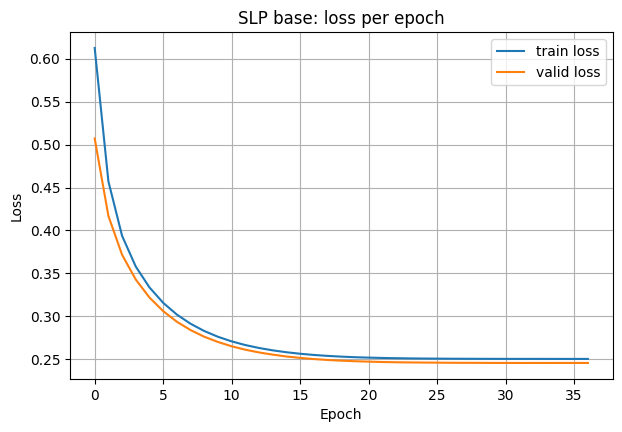

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 937us/step


,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,SLP,test,0.899213,0.899217,0.899211,0.899212,0.962109,0.252532,base


In [6]:
from tensorflow import keras

slp_base = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(1, activation="sigmoid"),
])

slp_base.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
)

early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=0,
)

history_slp_base = slp_base.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=40,
    batch_size=512,
    callbacks=[early_stop],
    verbose=0,
)

train_loss_base = history_slp_base.history["loss"]
valid_loss_base = history_slp_base.history["val_loss"]
plot_learning_curve(train_loss_base, valid_loss_base, title="SLP base: loss per epoch")

proba_test_base = slp_base.predict(X_test_scaled).ravel()
m_test_base = compute_metrics(y_test, proba_test_base)
add_result("SLP", "test", m_test_base, note="base")

results_df().query("model == 'SLP'")

### Optuna

Теперь подберем гиперпараметры для SLP с помощью Optuna. Чтобы не растягивать время подбора, сузим диапазоны:

- `learning_rate`: 3e-4..1e-2 (log),
- `batch_size`: {512, 1024},
- `l2`-регуляризация: 1e-6..1e-3 (log).

Оптимизируем `macro-F1` на валидации.

In [7]:
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import MedianPruner
from tensorflow.keras import regularizers

def build_slp_model(lr: float, l2: float) -> keras.Model:
    model = keras.Sequential([
        keras.layers.Input(shape=(input_dim,)),
        keras.layers.Dense(
            1,
            activation="sigmoid",
            kernel_regularizer=regularizers.l2(l2),
        ),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
    )
    return model

def objective_slp(trial):
    lr = trial.suggest_float("learning_rate", 3e-4, 1e-2, log=True)
    l2 = trial.suggest_float("l2", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [512, 1024])

    model = build_slp_model(lr=lr, l2=l2)

    early_stop_trial = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=0,
    )

    model.fit(
        X_train_scaled,
        y_train,
        validation_data=(X_valid_scaled, y_valid),
        epochs=40,
        batch_size=batch_size,
        callbacks=[early_stop_trial],
        verbose=0,
    )

    proba_valid = model.predict(X_valid_scaled).ravel()
    return compute_metrics(y_valid, proba_valid)["macro_f1"]

study_slp = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=0),
)
study_slp.optimize(objective_slp, n_trials=12, show_progress_bar=True)

best_slp_params = study_slp.best_params
print("Number of finished trials:", len(study_slp.trials))
print("Best trial:")
best_trial = study_slp.best_trial
print("Value (macro-F1):", best_trial.value)
print("Params:")
for k, v in best_trial.params.items():
    print(f"{k}: {v}")


[I 2025-11-15 12:20:29,999] A new study created in memory with name: no-name-399dc191-7c3d-4b9a-b448-2a9f796c3ab5


  0%|          | 0/12 [00:00<?, ?it/s]

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step
[I 2025-11-15 12:20:52,709] Trial 0 finished with value: 0.9034744288595244 and parameters: {'learning_rate': 0.0011155792840695788, 'l2': 0.0007114476009343421, 'batch_size': 512}. Best is trial 0 with value: 0.9034744288595244.
814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
[I 2025-11-15 12:21:07,156] Trial 1 finished with value: 0.8996289441336676 and parameters: {'learning_rate': 0.000518464143210523, 'l2': 2.9375384576328313e-06, 'batch_size': 1024}. Best is trial 0 with value: 0.9034744288595244.
814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 913us/step
[I 2025-11-15 12:21:21,341] Trial 2 finished with value: 0.9035899810870219 and parameters: {'learning_rate': 0.0024691446306928408, 'l2': 0.000133112160807369, 'batch_size': 1024}. Best is trial 2 with value: 0.9035899810870219.
814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
[I 2025-11-15 12:21:35,581] Trial 3 finished with value: 0.903052733705201 and parameters: {'learning_rate': 0.005556872843629611, 'l2': 4.

Обучим SLP модель на лучших параметрах 

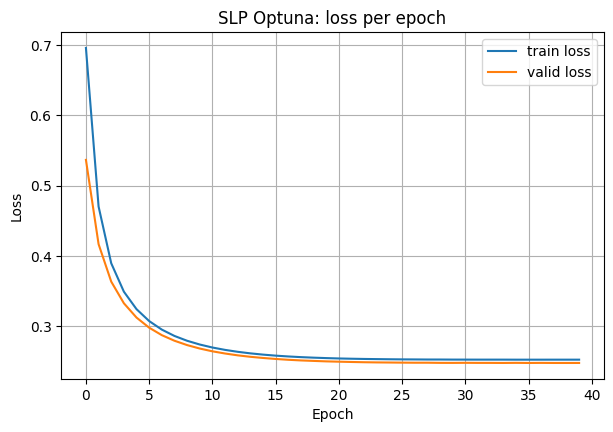

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 969us/step


,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,SLP,test,0.899213,0.899217,0.899211,0.899212,0.962109,0.252532,base
1,SLP,test,0.899021,0.899021,0.899020,0.899020,0.962122,0.252544,optuna


In [8]:
slp_opt = build_slp_model(
    lr=best_slp_params["learning_rate"],
    l2=best_slp_params["l2"],
)

early_stop_opt = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=0,
)

history_slp_opt = slp_opt.fit(
    X_train_scaled,
    y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=40,
    batch_size=best_slp_params["batch_size"],
    callbacks=[early_stop_opt],
    verbose=0,
)

train_loss_opt = history_slp_opt.history["loss"]
valid_loss_opt = history_slp_opt.history["val_loss"]
plot_learning_curve(train_loss_opt, valid_loss_opt, title="SLP Optuna: loss per epoch")

proba_test_opt = slp_opt.predict(X_test_scaled).ravel()
m_test_opt = compute_metrics(y_test, proba_test_opt)
add_result("SLP", "test", m_test_opt, note="optuna")

results_df().query("model == 'SLP'")

### SLP - вывод

Обе версии однослойного перцептрона дают очень близкие результаты:  
base - accuracy/F1 = 0.8990, ROC-AUC = 0.962;  
Optuna - accuracy/F1 = 0.8996, ROC-AUC = 0.962, logloss меняется совсем незначительно.

На графиках loss плавно падает и выходит на плато, кривые train и valid лежат рядом - явного переобучения нет.  
Подбор гиперпараметров чуть поправил шаг обучения и регуляризацию, но радикально качество не изменил: для этой задачи SLP ведет себя как аккуратная линейная модель и служит скорее базовой точкой для сравнения с более сложными архитектурами.

## MLP

Построим полносвязную сеть с тремя скрытыми слоями поверх стандартизированных признаков.  
Сначала обучим базовую конфигурацию, затем подберем гиперпараметры через Optuna и сравним качество.

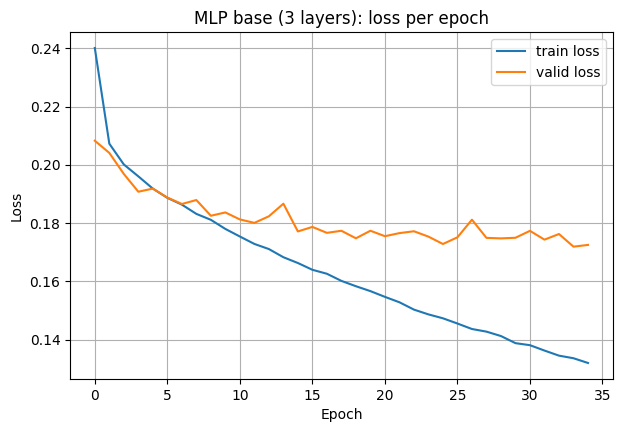

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,MLP,test,0.930862,0.930884,0.930859,0.930861,0.98188,0.177843,base


In [9]:
from tensorflow.keras import layers

input_dim = X_train_scaled.shape[1]

def build_mlp_base():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation="relu"),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

mlp_base = build_mlp_base()
history_base = mlp_base.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=35,
    batch_size=512,
    verbose=0,
)

plot_learning_curve(history_base.history["loss"],
                    history_base.history["val_loss"],
                    title="MLP base (3 layers): loss per epoch")

proba_test_base = mlp_base.predict(X_test_scaled).ravel()
m_test_base = compute_metrics(y_test, proba_test_base)
add_result("MLP", "test", m_test_base, note="base")

results_df().query("model == 'MLP'")

### MLP с Optuna

Подберем гиперпараметры для трехслойного MLP:

- `units1  {128, 192, 256}`
- `units2  [64, 224]` с шагом 32
- `units3  [32, 128]` с шагом 32
- `dropout  [0.0, 0.35]`
- `L2  [1e-5, 5e-3]` (log-scale)
- `learning_rate  [4e-4, 2.5e-3]` (log-scale)
- `batch_size  {256, 512}`
- `epochs  [22, 40]`

Оптимизируем macro-F1 на валидации.

In [10]:
def build_mlp_optuna(trial):
    units1 = trial.suggest_int("units1", 128, 256, step=64)
    units2 = trial.suggest_int("units2", 64, 224, step=32)
    units3 = trial.suggest_int("units3", 32, 128, step=32)
    dropout = trial.suggest_float("dropout", 0.0, 0.35)
    l2_val = trial.suggest_float("l2", 1e-5, 5e-3, log=True)
    lr = trial.suggest_float("learning_rate", 4e-4, 2.5e-3, log=True)

    reg = regularizers.l2(l2_val)

    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(units1, activation="relu", kernel_regularizer=reg),
        layers.Dropout(dropout),
        layers.Dense(units2, activation="relu", kernel_regularizer=reg),
        layers.Dropout(dropout),
        layers.Dense(units3, activation="relu", kernel_regularizer=reg),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def objective_mlp(trial):
    batch_size = trial.suggest_categorical("batch_size", [256, 512])
    epochs = trial.suggest_int("epochs", 22, 40)

    model = build_mlp_optuna(trial)
    history = model.fit(
        X_train_scaled, y_train,
        validation_data=(X_valid_scaled, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
    )

    proba_valid = model.predict(X_valid_scaled, verbose=0).ravel()
    metrics_valid = compute_metrics(y_valid, proba_valid)
    trial.set_user_attr("history", history.history)
    return metrics_valid["macro_f1"]


study_mlp = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=4, n_warmup_steps=0),
)
study_mlp.optimize(objective_mlp, n_trials=16, show_progress_bar=True)

print("Number of finished trials:", len(study_mlp.trials))
print("Best trial:")
best_trial_mlp = study_mlp.best_trial
print("Value (macro-F1):", best_trial_mlp.value)
print("Params:")
for k, v in best_trial_mlp.params.items():
    print(f"{k}: {v}")

[I 2025-11-15 12:24:59,618] A new study created in memory with name: no-name-ae68b363-4364-4f2f-93df-2bc66ace1248


  0%|          | 0/16 [00:00<?, ?it/s]

[I 2025-11-15 12:25:50,542] Trial 0 finished with value: 0.917761595096374 and parameters: {'batch_size': 512, 'epochs': 35, 'units1': 192, 'units2': 64, 'units3': 32, 'dropout': 0.02032926425886981, 'l2': 0.002176624112345368, 'learning_rate': 0.0012035812606397682}. Best is trial 0 with value: 0.917761595096374.
[I 2025-11-15 12:27:30,267] Trial 1 finished with value: 0.9297435796827602 and parameters: {'batch_size': 256, 'epochs': 40, 'units1': 256, 'units2': 96, 'units3': 32, 'dropout': 0.06419157844870184, 'l2': 6.62431060594998e-05, 'learning_rate': 0.0010464130549646918}. Best is trial 1 with value: 0.9297435796827602.
[I 2025-11-15 12:28:46,098] Trial 2 finished with value: 0.9205665753802477 and parameters: {'batch_size': 256, 'epochs': 33, 'units1': 128, 'units2': 96, 'units3': 64, 'dropout': 0.15962449447596255, 'l2': 0.0013157287601765638, 'learning_rate': 0.0005767350750762508}. Best is trial 1 with value: 0.9297435796827602.
[I 2025-11-15 12:29:22,074] Trial 3 finished wi

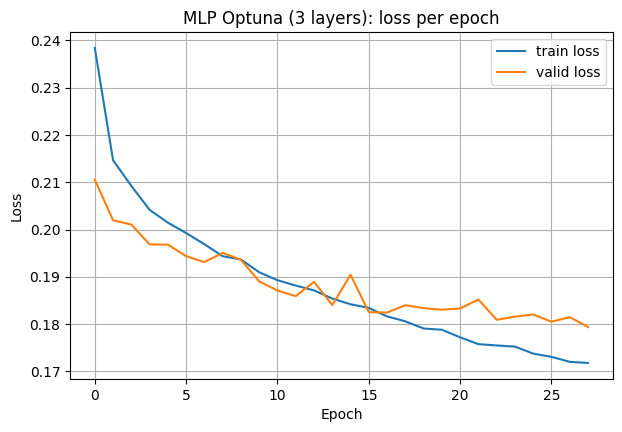

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,MLP,test,0.930862,0.930884,0.930859,0.930861,0.981880,0.177843,base
1,MLP,test,0.929326,0.929329,0.929328,0.929326,0.981932,0.173622,optuna


In [11]:
best_mlp_params = best_trial_mlp.params.copy()
best_mlp = build_mlp_optuna(best_trial_mlp)

history_best = best_mlp.fit(
    X_train_scaled, y_train,
    validation_data=(X_valid_scaled, y_valid),
    epochs=best_mlp_params["epochs"],
    batch_size=best_mlp_params["batch_size"],
    verbose=0,
)

plot_learning_curve(history_best.history["loss"],
                    history_best.history["val_loss"],
                    title="MLP Optuna (3 layers): loss per epoch")

proba_test_opt = best_mlp.predict(X_test_scaled).ravel()
m_test_opt = compute_metrics(y_test, proba_test_opt)
add_result("MLP", "test", m_test_opt, note="optuna")

results_df().query("model == 'MLP'")

### MLP - вывод

По тесту обе версии MLP дают примерно одинаковый результат:

* base: accuracy/macro-F1 = **0.931**, ROC-AUC = **0.982**, logloss = **0.178**
* Optuna: accuracy/macro-F1 = **0.929**, ROC-AUC = **0.982**, logloss = **0.174**

Подбор гиперпараметров чуть улучшил logloss и практически не тронул ROC-AUC, но при этом базовая конфигурация сохраняет небольшое преимущество по accuracy/F1. То есть Optuna здесь не дала явного выигрыша, скорее сделала модель немного “мягче” с точки зрения ошибки.

По графикам видно, что train-loss в обоих случаях уверенно падает, а valid-loss сначала снижается, а затем выходит на плато и начинает немного шуметь. Это похоже на легкое переобучение после 15-20 эпох, но без резкого роста ошибки. В целом, трехслойный MLP хорошо ложится на данные, но запас для улучшения за счет одних только архитектурных tweak’ов уже небольшой.


### Подготовка данных для RNN/GRU

Для рекуррентных сетей вход должен быть в формате `(batch, timesteps, features)`. Здесь будем рассматривать каждый объект как последовательность длиной `n_features` с одним каналом

In [13]:
n_features = X_train_scaled.shape[1]

X_train_seq = X_train_scaled.reshape(-1, n_features, 1)
X_valid_seq = X_valid_scaled.reshape(-1, n_features, 1)
X_test_seq  = X_test_scaled.reshape(-1, n_features, 1)

print("RNN input shapes:")
print("train:", X_train_seq.shape)
print("valid:", X_valid_seq.shape)
print("test :", X_test_seq.shape)

RNN input shapes:
train: (121496, 19, 1)
valid: (26035, 19, 1)
test : (26035, 19, 1)


## RNN

Обучим простую RNN с одним рекуррентным слоем и полносвязным выходом поверх него.
Используем `BinaryCrossentropy`, оптимизатор Adam и фиксированное число эпох=30.

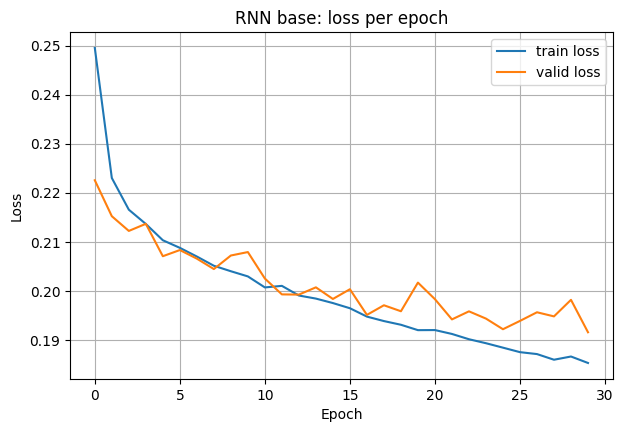

,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
2,RNN,test,0.918994,0.919161,0.918983,0.918984,0.976516,0.197605,base


In [14]:
rnn_base = keras.Sequential([
    layers.Input(shape=(n_features, 1)),
    layers.SimpleRNN(64, activation="tanh"),
    layers.Dense(1, activation="sigmoid"),
])

rnn_base.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history_rnn_base = rnn_base.fit(
    X_train_seq, y_train,
    validation_data=(X_valid_seq, y_valid),
    epochs=30,
    batch_size=256,
    verbose=0,
)

plot_learning_curve(
    history_rnn_base.history["loss"],
    history_rnn_base.history["val_loss"],
    title="RNN base: loss per epoch",
)

proba_test_rnn_base = rnn_base.predict(X_test_seq, verbose=0).ravel()
metrics_rnn_base = compute_metrics(y_test, proba_test_rnn_base)
add_result("RNN", "test", metrics_rnn_base, note="base")

results_df().query("model == 'RNN'")

### RNN с Optuna

Подберем гиперпараметры простой рекуррентной сети (SimpleRNN), оптимизируя macro-F1 на валидации.

Диапазоны:
- число нейронов в RNN-слое: `units`  {32, 64, 96, 128}
- dropout: `dropout`  [0.0, 0.4]
- рекуррентный dropout: `recurrent_dropout`  [0.0, 0.3]
- L2-регуляризация: `l2`  [1e-6, 1e-3] (log-scale)
- скорость обучения: `learning_rate`  [3e-4, 3e-3] (log-scale)
- размер батча: `batch_size`  {256, 512}
- число эпох: `epochs`  [15, 35]

In [15]:
def build_rnn_optuna(trial):
    units = trial.suggest_int("units", 32, 128, step=32)
    dropout = trial.suggest_float("dropout", 0.0, 0.4)
    rec_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.3)
    l2_val = trial.suggest_float("l2", 1e-6, 1e-3, log=True)
    lr = trial.suggest_float("learning_rate", 3e-4, 3e-3, log=True)

    reg = regularizers.l2(l2_val)

    model = keras.Sequential([
        layers.Input(shape=(n_features, 1)),
        layers.SimpleRNN(
            units,
            activation="tanh",
            dropout=dropout,
            recurrent_dropout=rec_dropout,
            kernel_regularizer=reg,
            recurrent_regularizer=reg,
        ),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

def objective_rnn(trial):
    batch_size = trial.suggest_categorical("batch_size", [256, 512])
    epochs = trial.suggest_int("epochs", 15, 35)

    model = build_rnn_optuna(trial)
    history = model.fit(
        X_train_seq, y_train,
        validation_data=(X_valid_seq, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        verbose=0,
    )

    proba_valid = model.predict(X_valid_seq, verbose=0).ravel()
    metrics_valid = compute_metrics(y_valid, proba_valid)
    trial.set_user_attr("history", history.history)
    return metrics_valid["macro_f1"]

study_rnn = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=4, n_warmup_steps=0),
)
study_rnn.optimize(objective_rnn, n_trials=12, show_progress_bar=True)

print("Number of finished trials:", len(study_rnn.trials))
print("Best trial:")
best_trial_rnn = study_rnn.best_trial
print("Value (macro-F1):", best_trial_rnn.value)
print("Params:")
for k, v in best_trial_rnn.params.items():
    print(f"{k}: {v}")

[I 2025-11-15 12:47:54,848] A new study created in memory with name: no-name-e7c0bfd4-7c2f-46f2-9212-b28d8d87aca2


  0%|          | 0/12 [00:00<?, ?it/s]

[I 2025-11-15 12:50:37,174] Trial 0 finished with value: 0.9148392084292554 and parameters: {'batch_size': 512, 'epochs': 30, 'units': 96, 'dropout': 0.06240745617697461, 'recurrent_dropout': 0.04679835610086079, 'l2': 1.493656855461763e-06, 'learning_rate': 0.0022044355215811344}. Best is trial 0 with value: 0.9148392084292554.
[I 2025-11-15 12:52:24,465] Trial 1 finished with value: 0.9109239761872134 and parameters: {'batch_size': 512, 'epochs': 15, 'units': 128, 'dropout': 0.3329770563201687, 'recurrent_dropout': 0.06370173320348284, 'l2': 3.5113563139704077e-06, 'learning_rate': 0.0004576418837415782}. Best is trial 0 with value: 0.9148392084292554.
[I 2025-11-15 12:54:01,253] Trial 2 finished with value: 0.9114532624213707 and parameters: {'batch_size': 512, 'epochs': 24, 'units': 64, 'dropout': 0.2447411578889518, 'recurrent_dropout': 0.04184815819561255, 'l2': 7.523742884534855e-06, 'learning_rate': 0.0006974018546851301}. Best is trial 0 with value: 0.9148392084292554.
[I 2025

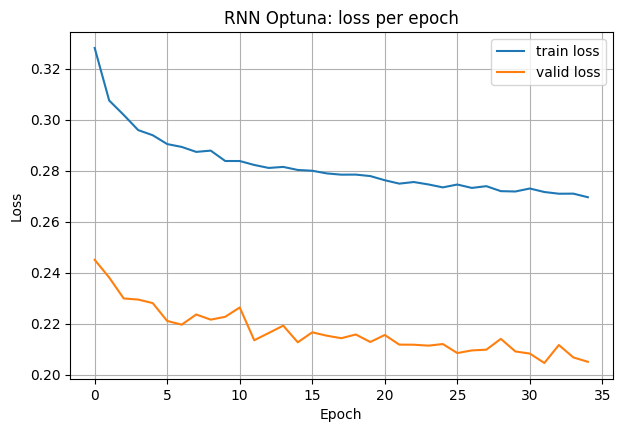

,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
2,RNN,test,0.918994,0.919161,0.918983,0.918984,0.976516,0.197605,base
3,RNN,test,0.917534,0.917541,0.917532,0.917533,0.976164,0.198717,optuna


In [16]:
best_rnn_params = best_trial_rnn.params.copy()
best_rnn = build_rnn_optuna(best_trial_rnn)

history_best_rnn = best_rnn.fit(
    X_train_seq, y_train,
    validation_data=(X_valid_seq, y_valid),
    epochs=best_rnn_params["epochs"],
    batch_size=best_rnn_params["batch_size"],
    verbose=0,
)

plot_learning_curve(
    history_best_rnn.history["loss"],
    history_best_rnn.history["val_loss"],
    title="RNN Optuna: loss per epoch"
)

proba_test_rnn_opt = best_rnn.predict(X_test_seq, verbose=0).ravel()
m_test_rnn_opt = compute_metrics(y_test, proba_test_rnn_opt)
add_result("RNN", "test", m_test_rnn_opt, note="optuna")

results_df().query("model == 'RNN'")

### RNN - вывод

Базовая RNN на тесте дает accuracy/macro-F1 = 0.919, ROC-AUC = 0.977, logloss = 0.198.  
После подбора гиперпараметров через Optuna качество почти не меняется и даже чуть проседает
(accuracy/F1 = 0.918, logloss = 0.199).

По кривым видно, что базовая модель постепенно снижает loss и разрыв между train и valid небольшой.  
У модели с Optuna train-loss заметно выше, чем у базовой, а val-loss при этом медленно ползет вниз.
То есть подобранная конфигурация получилась скорее недообученной, чем переобученной.

Если смотреть на лучшие параметры Optuna, то картина логична:  
learning_rate около 8e-4 (меньше типичного 1e-3-2e-3), dropout и recurrent_dropout вместе с l2 делают
регуляризацию довольно жесткой, а batch_size = 512 сглаживает градиенты. Все это замедляет обучение,
и за 35 эпох модель просто не успевает. Чтобы получить из RNN что-то лучше базовой версии, нужно расширять пространство поиска: разрешить больше эпох, чуть поднять learning_rate, ослабить регуляризацию и увеличить число trial’ов. В текущей постановке RNN работает стабильно, но заметного выигрыша от Optuna не получилось.

## GRU

Теперь посмотрим на рекуррентную архитектуру с обновляемой памятью.  
GRU можно считать вариантом RNN, где состояние на каждом шаге обновляется через набор "гейтов" (update/reset), поэтому модель лучше держит долгосрочные зависимости, чем простая RNN.

В нашей постановке последовательность - это вектор признаков автомобиля, который мы трактуем как упорядоченный набор шагов длины `n_features` с одномерным "наблюдением" на каждом шаге.  
Соберем простую схему: `GRU(units=64) -> Dense(1, sigmoid)`

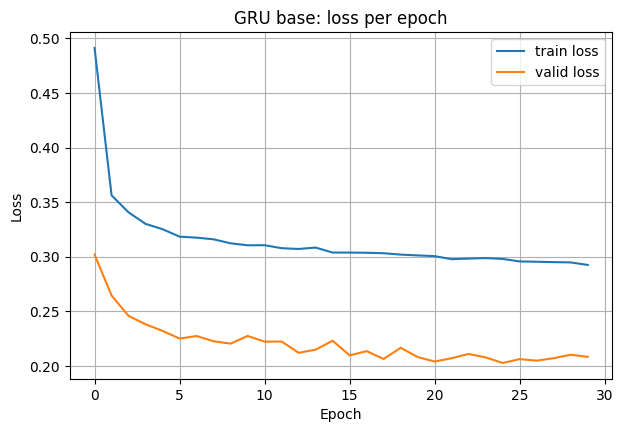

,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,GRU,test,0.913616,0.913739,0.913607,0.913609,0.974624,0.206118,base


In [18]:
from tensorflow.keras.callbacks import EarlyStopping

gru_base = keras.Sequential([
    layers.Input(shape=(n_features, 1)),
    layers.GRU(64, dropout=0.2, recurrent_dropout=0.0),
    layers.Dense(1, activation="sigmoid"),
])

gru_base.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

history_gru_base = gru_base.fit(
    X_train_seq, y_train,
    validation_data=(X_valid_seq, y_valid),
    epochs=40,
    batch_size=256,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=5,
            restore_best_weights=True,
        )
    ],
    verbose=0,
)

plot_learning_curve(
    history_gru_base.history["loss"],
    history_gru_base.history["val_loss"],
    title="GRU base: loss per epoch",
)

proba_test_gru_base = gru_base.predict(X_test_seq, verbose=0).ravel()
m_test_gru_base = compute_metrics(y_test, proba_test_gru_base)
add_result("GRU", "test", m_test_gru_base, note="base")

results_df().query("model == 'GRU'")

### GRU с Optuna

Диапазоны:
- units: 32..96 (шаг 32)  
- dropout: 0.0..0.3  
- recurrent_dropout: 0.0..0.2  
- l2: [1e-6, 1e-4] (log)  
- learning_rate: [1e-3, 3e-3] (log)  
- batch_size: {256, 512}  
- epochs: 10..22  

Модель: `GRU -> Dense(1, sigmoid)`

In [20]:
def build_gru_optuna(trial):
    units = trial.suggest_int("units", 32, 96, step=32)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    rec_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.2)
    l2_val = trial.suggest_float("l2", 1e-6, 1e-4, log=True)
    lr = trial.suggest_float("learning_rate", 1e-3, 3e-3, log=True)

    reg = regularizers.l2(l2_val)

    model = keras.Sequential([
        layers.Input(shape=(n_features, 1)),
        layers.GRU(
            units,
            dropout=dropout,
            recurrent_dropout=rec_dropout,
            kernel_regularizer=reg,
        ),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model


def objective_gru(trial):
    batch_size = trial.suggest_categorical("batch_size", [256, 512])
    epochs = trial.suggest_int("epochs", 10, 22)

    model = build_gru_optuna(trial)
    history = model.fit(
        X_train_seq, y_train,
        validation_data=(X_valid_seq, y_valid),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                patience=3,
                restore_best_weights=True,
            )
        ],
        verbose=0,
    )

    proba_valid = model.predict(X_valid_seq, verbose=0).ravel()
    metrics_valid = compute_metrics(y_valid, proba_valid)
    trial.set_user_attr("history", history.history)
    return metrics_valid["macro_f1"]


study_gru = optuna.create_study(
    direction="maximize",
    sampler=TPESampler(seed=42),
    pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=0),
)
study_gru.optimize(objective_gru, n_trials=8, show_progress_bar=True)

print("Number of finished trials:", len(study_gru.trials))
print("Best trial:")
best_trial_gru = study_gru.best_trial
print("  Value (macro-F1):", best_trial_gru.value)
print("  Params:")
for k, v in best_trial_gru.params.items():
    print(f"{k}: {v}")

[I 2025-11-15 13:55:55,858] A new study created in memory with name: no-name-ad133e8d-9170-4d1d-b93b-addc920d0bc8


  0%|          | 0/8 [00:00<?, ?it/s]

[I 2025-11-15 13:58:21,736] Trial 0 finished with value: 0.9217501195973562 and parameters: {'batch_size': 512, 'epochs': 19, 'units': 64, 'dropout': 0.04680559213273095, 'recurrent_dropout': 0.031198904067240532, 'l2': 1.306673923805328e-06, 'learning_rate': 0.0025898287605281714}. Best is trial 0 with value: 0.9217501195973562.
[I 2025-11-15 14:00:16,960] Trial 1 finished with value: 0.9141053206244283 and parameters: {'batch_size': 512, 'epochs': 10, 'units': 96, 'dropout': 0.2497327922401265, 'recurrent_dropout': 0.04246782213565523, 'l2': 2.310201887845294e-06, 'learning_rate': 0.00122322455316012}. Best is trial 0 with value: 0.9217501195973562.
[I 2025-11-15 14:01:15,890] Trial 2 finished with value: 0.9108114172914693 and parameters: {'batch_size': 512, 'epochs': 15, 'units': 32, 'dropout': 0.18355586841671384, 'recurrent_dropout': 0.027898772130408367, 'l2': 3.839629299804171e-06, 'learning_rate': 0.0014955434061021927}. Best is trial 0 with value: 0.9217501195973562.
[I 2025-

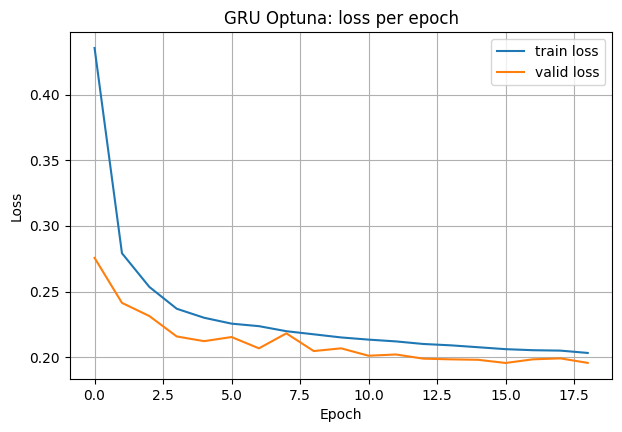

,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,GRU,test,0.913616,0.913739,0.913607,0.913609,0.974624,0.206118,base
1,GRU,test,0.916727,0.916773,0.916733,0.916726,0.975633,0.200576,optuna


In [21]:
best_gru_params = best_trial_gru.params.copy()
best_gru = build_gru_optuna(best_trial_gru)

history_gru_best = best_gru.fit(
    X_train_seq, y_train,
    validation_data=(X_valid_seq, y_valid),
    epochs=best_gru_params["epochs"],
    batch_size=best_gru_params["batch_size"],
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True,
        )
    ],
    verbose=0,
)

plot_learning_curve(
    history_gru_best.history["loss"],
    history_gru_best.history["val_loss"],
    title="GRU Optuna: loss per epoch",
)

proba_test_gru_opt = best_gru.predict(X_test_seq, verbose=0).ravel()
m_test_gru_opt = compute_metrics(y_test, proba_test_gru_opt)
add_result("GRU", "test", m_test_gru_opt, note="optuna")

results_df().query("model == 'GRU'")

### GRU - вывод

* **База:** accuracy/macro-F1 = **0.914**, ROC-AUC = **0.9746**, logloss = **0.206**.
* **Optuna:** accuracy/macro-F1 = **0.917**, ROC-AUC = **0.9756**, logloss = **0.201**.

Разница небольшая, но в пользу настроенной модели: логлосс ниже, ROC-AUC чуть выше, точность/F1 подросли на пару десятых процента.

По графикам видно, что базовая GRU долго «тащится» с довольно высоким train-loss и постепенно ползет вниз, валидация стабилизируется около 0.21 и почти не меняется. В оптимизированном варианте обе кривые падают заметно быстрее, валидная ошибка уходит чуть ниже и держится без явного развала.

Гиперпараметры лучшего trial’а (меньше dropout, немного выше learning rate, меньше эпох) в сумме делают обучение более бодрым, но не слишком агрессивным. В итоге GRU с Optuna немного выигрывает у базовой по всем метрикам, хотя запас прочности по качеству у этой архитектуры в нашей постановке всё равно ниже, чем у MLP.

## Итоговые результаты:

In [22]:
df_all = results_df().sort_values(by="macro_f1", ascending=False).reset_index(drop=True)
display(df_all)

,model,split,accuracy,precision,recall,macro_f1,roc_auc,logloss,note
0,MLP,test,0.930862,0.930884,0.930859,0.930861,0.981880,0.177843,base
1,MLP,test,0.929326,0.929329,0.929328,0.929326,0.981932,0.173622,optuna
2,RNN,test,0.918994,0.919161,0.918983,0.918984,0.976516,0.197605,base
3,RNN,test,0.917534,0.917541,0.917532,0.917533,0.976164,0.198717,optuna
4,GRU,test,0.916727,0.916773,0.916733,0.916726,0.975633,0.200576,optuna
5,GRU,test,0.913616,0.913739,0.913607,0.913609,0.974624,0.206118,base
6,SLP,test,0.899213,0.899217,0.899211,0.899212,0.962109,0.252532,base
7,SLP,test,0.899021,0.899021,0.899020,0.899020,0.962122,0.252544,optuna


### Итоговый вывод по всем моделям

**Общая картинка**

По таблице видно вполне понятную лестницу по качеству:

* сверху - трехслойный MLP (base и Optuna);
* ниже - RNN и GRU;
* заметно слабее остальных - однослойный перцептрон.

По macro-F1 и accuracy лучший результат дает базовый MLP: около 0.931 по всем трем метрикам (accuracy/precision/recall), ROC-AUC = 0.982, logloss = 0.178.
Версия с Optuna немного уступает по accuracy/F1 (0.929), но выигрывает по logloss (0.174) и почти не отличается по ROC-AUC. То есть MLP в любом варианте уверенно лидер.

**Почему MLP оказался лучшим**

У нас табличные данные, много числовых признаков и нет естественной временной структуры. В такой постановке обычная полносвязная сеть хорошо чувствует себя: три скрытых слоя с ReLU успевают выучить нелинейные зависимости между признаками, но модель при этом не слишком тяжелая и нормально оптимизируется простым Adam на стандартизированных признаках.
Базовые гиперпараметры оказались "в точке": сеть достаточно емкая, но без сильного переобучения, поэтому Optuna уже не смогла сильно улучшить результат и лишь немного сместила баланс в сторону меньшего logloss.

**RNN и GRU**

Recurrent-сети (RNN и GRU) здесь работают хуже MLP: macro-F1 держится в районе 0.917–0.919, ROC-AUC около 0.976, logloss около 0.20.
Причины:

* мы подаем "последовательность по признакам", а не реальную временную серию, то есть архитектура изначально не использует свое основное преимущество - работу с длинными временными зависимостями;
* обучение RNN/GRU в таком формате сложнее: больше параметров, чувствительность к learning rate и регуляризации.

Отдельно видно, что:

* у RNN версия с Optuna недообучилась: train-loss у нее заметно выше, чем у базовой, зато регуляризация и маленький шаг обучения делают модель очень осторожной, из-за чего качество на тесте чуть проседает;
* у GRU наоборот Optuna слегка помогает - логлосс падает с 0.206 до 0.201, macro-F1 и ROC-AUC тоже немного растут. Здесь поиск подобрал более удобное сочетание units, dropout и learning rate, поэтому сеть успевает выучить что-то полезное, не уходя в жесткое переобучение.

В целом обе рекуррентные архитектуры получаются "рабочими", но в этой задаче объективно проигрывают обычному MLP, потому что их сильные стороны просто не востребованы.

**Однослойный перцептрон**

SLP заметно слабее остальных: macro-F1 и accuracy около 0.899, ROC-AUC = 0.962, logloss = 0.253.
Это ожидаемо: модель по сути реализует одну логистическую регрессию. При такой формулировке она способна строить только одну линейную границу в пространстве признаков, а данные явно требуют более сложной нелинейной аппроксимации. Optuna почти ничего не меняет - база и настроенная версия дают практически одинаковые числа.

**Итог**

Для задачи бинарной классификации автомобилей по цене лучшей оказывается трехслойная полносвязная сеть.
RNN и GRU работают чуть хуже и выглядят избыточными для табличных признаков без явной последовательной структуры. Однослойный перцептрон упирается в свою линейность и служит скорее "базовой планкой", от которой удобно отталкиваться.
Optuna в целом полезна: для GRU дает заметное улучшение, для MLP слегка улучшает логарифмическую потерю, а на SLP и RNN помогает меньше, что связано с ограничениями самих архитектур и выбранным пространством гиперпараметров.
